# Cassandra

Dataset : taxi_trip_data.csv

## Connection

In [112]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json

# This secure connect bundle is autogenerated when you download your SCB,
# if yours is different update the file name below
cloud_config= {
  'secure_connect_bundle': './cassandra_needs/secure-connect-taxi-trip.zip'
}

# This token JSON file is autogenerated when you download your token,
# if yours is different update the file name below
with open("./cassandra_needs/taxi_trip-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
  print(row[0])
else:
  print("An error occurred.")

4.0.0.6816


## Import and Read

In [113]:
import pandas as pd

taxi_trip_data = pd.read_csv('./datasets/taxi_trip_data.csv', nrows=20_000)

taxi_zone_geo_data = pd.read_csv('./datasets/taxi_zone_geo.csv')

In [114]:
taxi_trip_data.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'rate_code', 'store_and_fwd_flag', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'imp_surcharge', 'total_amount', 'pickup_location_id',
       'dropoff_location_id'],
      dtype='object')

In [115]:
taxi_zone_geo_data.columns

Index(['zone_id', 'zone_name', 'borough', 'zone_geom'], dtype='object')

## Data Preprocessing

### Drop Unnecessary Columns

In [116]:
taxi_trip_data.drop(
    columns=["store_and_fwd_flag", "rate_code", "total_amount"], inplace=True
)

### Drop rows with missing essential details


In [117]:
essential_columns = [
    "vendor_id",
    "pickup_datetime",
    "dropoff_datetime",
    "passenger_count",
    "trip_distance",
    "payment_type",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "imp_surcharge",
    "pickup_location_id",
    "dropoff_location_id",
]

### Drop Missing Values

In [118]:
taxi_trip_data.dropna(subset=essential_columns, inplace=True)
taxi_zone_geo_data.dropna(inplace=True)

## Remove IDs in pickup location IDs that are not present in zone IDs

In [119]:
taxi_trip_data = taxi_trip_data[taxi_trip_data['pickup_location_id'].isin(taxi_zone_geo_data['zone_id'])]

## Join Datasets

In [120]:
joined_data = pd.merge(
    taxi_trip_data,
    taxi_zone_geo_data,
    how="inner",
    left_on="pickup_location_id",
    right_on="zone_id",
)

In [121]:
joined_data.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'imp_surcharge', 'pickup_location_id',
       'dropoff_location_id', 'zone_id', 'zone_name', 'borough', 'zone_geom'],
      dtype='object')

## Cassandra

### Initiation

In [122]:
session.set_keyspace("taxi_trip_data")
row = cluster.metadata.keyspaces["taxi_trip_data"]

from pprint import pprint

pprint(row)

### Table Creation

In [123]:
session.execute(
    """
    CREATE TABLE IF NOT EXISTS taxi_trip_data.trip_data (
        trip_id int PRIMARY KEY,
        zone_name text,
        pickup_datetime TEXT,
        dropoff_datetime TEXT,
        passenger_count INT,
        payment_type TEXT,
        fare_amount DOUBLE,
        extra DOUBLE,
        mta_tax DOUBLE,
        tip_amount DOUBLE,
        tolls_amount DOUBLE,
        imp_surcharge DOUBLE,
    )
    """
)

In [124]:
joined_data.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'imp_surcharge', 'pickup_location_id',
       'dropoff_location_id', 'zone_id', 'zone_name', 'borough', 'zone_geom'],
      dtype='object')

### Insertion

In [125]:
import csv

ROW_LIMIT = 20_000
row_count = 0

with open("./datasets/joined_taxi_trip_data.csv", "r") as f:
    reader = csv.reader(f)  # Create a reader object.
    next(reader)  # Skip the header row.
    for row in reader:
        if row_count >= ROW_LIMIT:
            break
        trip_id = row_count
        zone_name = row[15]
        pickup_datetime = row[1]
        dropoff_datetime = row[2]
        passenger_count = row[3]
        payment_type = row[6]
        fare_amount = row[7]
        extra = row[8]
        mta_tax = row[9]
        tip_amount = row[10]
        tolls_amount = row[11]
        imp_surcharge = row[12]
        pickup_location_id = row[13]

        
        
        query = (
            f"INSERT INTO taxi_trip_data.trip_data (trip_id, zone_name, pickup_datetime, dropoff_datetime, passenger_count, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, imp_surcharge) VALUES ({trip_id}, '{zone_name}', '{pickup_datetime}', '{dropoff_datetime}', {passenger_count}, '{payment_type}', {fare_amount}, {extra}, {mta_tax}, {tip_amount}, {tolls_amount}, {imp_surcharge})"
        )
        try:
            session.execute(query)
        except Exception as e:
            print(e)
            break
        row_count += 1

errors={'01ac88f6-b79d-4938-ad9d-5597469bea97-us-east1.db.astra.datastax.com:29042:c39a5bc8-1a0c-4e01-ab3a-883b2afa0063': 'Client request timeout. See Session.execute[_async](timeout)'}, last_host=01ac88f6-b79d-4938-ad9d-5597469bea97-us-east1.db.astra.datastax.com:29042:c39a5bc8-1a0c-4e01-ab3a-883b2afa0063


## Calculations

### Trip Duration

In [126]:
session.execute(
    """
    ALTER TABLE taxi_trip_data.trip_data
    ADD trip_duration TEXT
    """
)

In [127]:
duration = session.execute(
    """
    SELECT trip_id, pickup_datetime, dropoff_datetime
    FROM trip_data
"""
)

duration = pd.DataFrame(duration)
duration["pickup_datetime"] = pd.to_datetime(duration["pickup_datetime"])
duration["dropoff_datetime"] = pd.to_datetime(duration["dropoff_datetime"])
duration["duration"] = duration["dropoff_datetime"] - duration["pickup_datetime"]

In [128]:
str(duration["duration"].max())

'0 days 23:58:59'

In [131]:
query = session.prepare(
    """
    UPDATE trip_data
    SET trip_duration = ?
    WHERE trip_id = ?
"""
)

for index, row in duration.iterrows():
    session.execute(query, [str(row["duration"]), int(row["trip_id"])], timeout=60)

### Total Trip Cost

In [ ]:
session.execute(
    """
    ALTER TABLE trip_data
    ADD total_trip_cost DOUBLE
    """
)

In [138]:
total_cost = session.execute(
    """
    SELECT trip_id, fare_amount, extra, mta_tax, tip_amount, tolls_amount, imp_surcharge
    FROM trip_data
"""
)

In [141]:

total_cost = pd.DataFrame(total_cost)

total_cost["total_trip_cost"] = (
    total_cost["fare_amount"]
    + total_cost["extra"]
    + total_cost["mta_tax"]
    + total_cost["tip_amount"]
    + total_cost["tolls_amount"]
    + total_cost["imp_surcharge"]
)

query = session.prepare(
    """
    UPDATE trip_data
    SET total_trip_cost = ?
    WHERE trip_id = ?
"""
)

for index, row in total_cost.iterrows():
    session.execute(query, [float(row["total_trip_cost"]), int(row["trip_id"])], timeout=60)

## What is the most common payment type used per time of day?
Hint: time of day meaning morning, afternoon or evening

In [142]:
session.execute(
    """
    CREATE TABLE IF NOT EXISTS taxi_trip_data.payment_type_by_time (
        time_of_day TEXT,
        payment_type TEXT,
        count INT,
        PRIMARY KEY (time_of_day, payment_type)
    )
    """
)

payment_type_by_time = session.execute(
    """
    SELECT pickup_datetime, payment_type
    FROM trip_data
"""
)

In [143]:
payment_type_by_time = pd.DataFrame(payment_type_by_time)
payment_type_by_time["pickup_datetime"] = pd.to_datetime(
    payment_type_by_time["pickup_datetime"]
)
payment_type_by_time["time_of_day"] = payment_type_by_time["pickup_datetime"].apply(
    lambda x: (
        "morning" if x.hour < 12 else "afternoon" if 12 <= x.hour < 18 else "evening"
    )
)

In [144]:
payment_type_by_time = (
    payment_type_by_time.groupby(["time_of_day", "payment_type"])
    .size()
    .reset_index(name="count")
)

query = session.prepare(
    """
    INSERT INTO payment_type_by_time (time_of_day, payment_type, count)
    VALUES (?, ?, ?)
"""
)

In [145]:
for index, row in payment_type_by_time.iterrows():
    session.execute(query, [row["time_of_day"], row["payment_type"], int(row["count"])])

### Visualization

In [181]:
payment_type_by_time = session.execute(
    """
    SELECT * FROM payment_type_by_time
"""
)

payment_type_by_time = pd.DataFrame(payment_type_by_time)

payment_type_by_time["payment_type"] = payment_type_by_time["payment_type"].apply(
    lambda x: "cash" if x == "1" else "card" if x == "2" else "no charge" if x == "3" else "dispute"
)

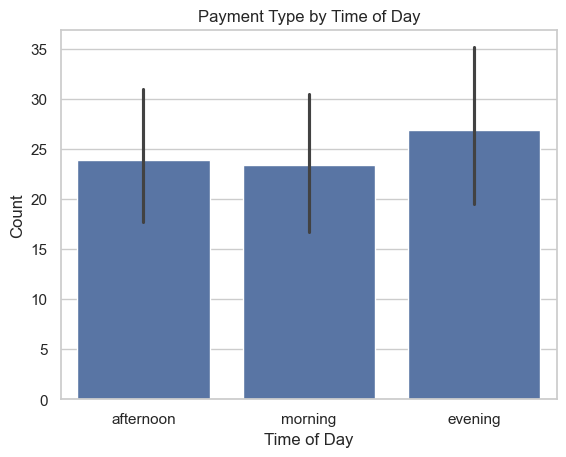

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    x="time_of_day", y="count", data=payment_type_by_time
)
plt.title("Payment Type by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.show()

## What is the average tip amount per passenger count? 

In [154]:
session.execute(
    """
    CREATE TABLE IF NOT EXISTS taxi_trip_data.tip_amount_by_passenger_count (
        passenger_count INT,
        avg_tip_amount DOUBLE,
        PRIMARY KEY (passenger_count)
    )
    """
)

tip_amount_by_passenger_count = session.execute(
    """
    SELECT passenger_count, tip_amount
    FROM trip_data
"""
)

tip_amount_by_passenger_count = pd.DataFrame(tip_amount_by_passenger_count)

tip_amount_by_passenger_count = (
    tip_amount_by_passenger_count.groupby("passenger_count")
    .agg({"tip_amount": "mean"})
    .reset_index()
)

query = session.prepare(
    """
    INSERT INTO tip_amount_by_passenger_count (passenger_count, avg_tip_amount)
    VALUES (?, ?)
"""
)

for index, row in tip_amount_by_passenger_count.iterrows():
    session.execute(query, [int(row["passenger_count"]), float(row["tip_amount"])])



### Visualization

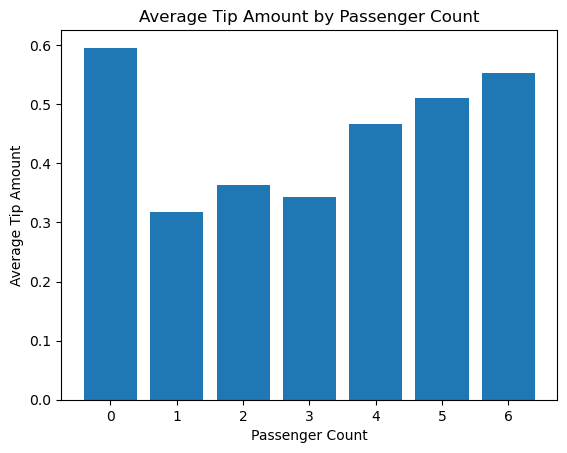

In [155]:
# Visualizing the data]
tip_amount_by_passenger_count = session.execute(
    """
    SELECT * FROM tip_amount_by_passenger_count
"""
)

tip_amount_by_passenger_count = pd.DataFrame(tip_amount_by_passenger_count)

plt.bar(tip_amount_by_passenger_count["passenger_count"], tip_amount_by_passenger_count["avg_tip_amount"])
plt.xlabel("Passenger Count")
plt.ylabel("Average Tip Amount")
plt.title("Average Tip Amount by Passenger Count")
plt.show()

## What are the best 5 locations for drivers to pick up passengers from?

In [156]:
## What are the best 5 locations for drivers to pick up passengers from?
session.execute(
    """
    CREATE TABLE IF NOT EXISTS taxi_trip_data.best_pickup_locations (
        zone_name TEXT,
        count INT,
        PRIMARY KEY (zone_name)
    )
    """
)

best_pickup_locations = session.execute(
    """
    SELECT zone_name
    FROM trip_data
"""
)

best_pickup_locations = pd.DataFrame(best_pickup_locations)

best_pickup_locations = best_pickup_locations.groupby("zone_name").size().reset_index(name="count")

best_pickup_locations = best_pickup_locations.sort_values(by="count", ascending=False).head(5)

query = session.prepare(
    """
    INSERT INTO best_pickup_locations (zone_name, count)
    VALUES (?, ?)
"""
)

for index, row in best_pickup_locations.iterrows():
    session.execute(query, [row["zone_name"], int(row["count"])])

### Visualization

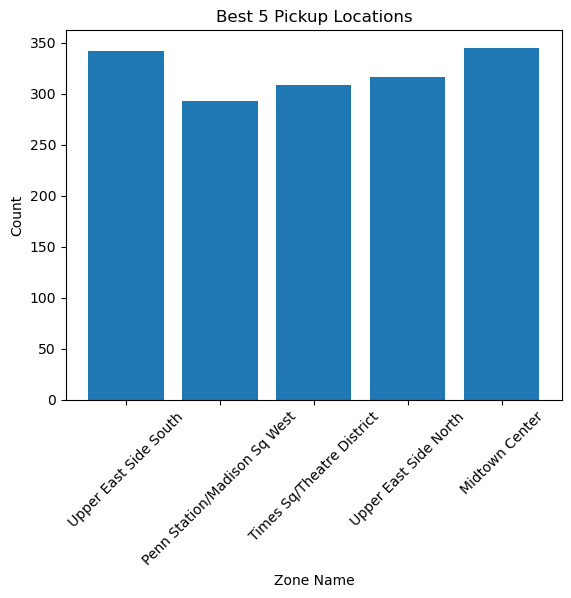

In [158]:
best_pickup_locations = session.execute(
    """
    SELECT * FROM best_pickup_locations
"""
)

best_pickup_locations = pd.DataFrame(best_pickup_locations)

fig, ax = plt.subplots()
ax.bar(best_pickup_locations["zone_name"], best_pickup_locations["count"])
ax.set_xlabel("Zone Name")
ax.set_ylabel("Count")
ax.set_title("Best 5 Pickup Locations")
plt.xticks(rotation=45)
plt.show()

## Bonus

### Correlation between trip distance and the tip amount


In [161]:
session.execute(
    """
    CREATE TABLE IF NOT EXISTS taxi_trip_data.trip_distance_tip_amount (
        trip_distance DOUBLE,
        tip_amount DOUBLE,
        PRIMARY KEY (trip_distance)
    )
    """
)

In [163]:
trip_distance_tip_amount = joined_data[["trip_distance", "tip_amount"]]
trip_distance_tip_amount = trip_distance_tip_amount.groupby("trip_distance").agg({"tip_amount": "mean"}).reset_index()

query = session.prepare(
    """
    INSERT INTO trip_distance_tip_amount (trip_distance, tip_amount)
    VALUES (?, ?)
"""
)

for index, row in trip_distance_tip_amount.iterrows():
    session.execute(query, [float(row["trip_distance"]), float(row["tip_amount"])])

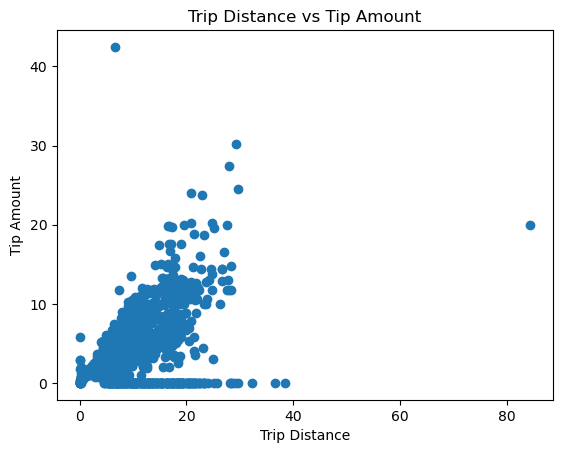

In [164]:
trip_distance_tip_amount = session.execute(
    """
    SELECT * FROM trip_distance_tip_amount
"""
)

trip_distance_tip_amount = pd.DataFrame(trip_distance_tip_amount)

plt.scatter(
    trip_distance_tip_amount["trip_distance"], trip_distance_tip_amount["tip_amount"]
)
plt.xlabel("Trip Distance")
plt.ylabel("Tip Amount")
plt.title("Trip Distance vs Tip Amount")
plt.show()

I Think there is corelation between the trip distance and the tip amount, it is somehow strange but understandable. Maybe When the Trip distance increase the amount increase so the passengers are not willing to pay more 

### Closing Connection

In [185]:
# Close the connection
cluster.shutdown()